# Relax Challenge 

**'takehome_users'**:
- object_id: the user's id
- creation_time: when they created their account
- name: the user's name
- email: email address
- creation_source: how their account was created. This takes on onevof 5 values:
    - PERSONAL_PROJECTS: invited to join another user's personal workspace
    - GUEST_INVITE: invited to an organization as a guest (limited permissions)
    - ORG_INVITE: invited to an organization (as a full member)
    - SIGNUP: signed up via the website
    - SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
- last_session_creation_time: unix timestamp of last login
- opted_in_to_mailing_list: whether they have opted into receiving marketing emails
- enabled_for_marketing_drip: whether they are on the regular marketing email drip
- org_id: the organization (group of users) they belong to
- invited_by_user_id: which user invited them to join (if applicable).

**'takehome_user_engagement'**: has a row for each day that a user logged into the product.

Defining an 'adopted user' as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

In [643]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [644]:
# Read in data
df = pd.read_csv('takehome_users.csv', encoding='latin1') # utf-8 encoding threw the following error:
                                                          # UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe6 in position 11: invalid continuation byte

In [645]:
df2 = pd.read_csv('takehome_user_engagement.csv')

In [646]:
# Examine data
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [647]:
df2.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [648]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [649]:
df2.nunique()

time_stamp    207220
user_id         8823
visited            1
dtype: int64

In [650]:
# Convert 'time_stamp' to datetime
df2['time_stamp'] = pd.to_datetime(df2['time_stamp'])

In [651]:
# Aggregate 'time_stamp' by week and indicate if each user logged in that week
weekly_logins = df2.groupby('user_id').resample('7D', on='time_stamp').count().rename(columns={'user_id':'login'}).reset_index()
# Create list of users who logged in at least 3 times in a week
adopted_users = list(weekly_logins['user_id'][weekly_logins['login'] >= 3].unique())

In [652]:
# Create target variable column 'adopted' and set to 0
df['adopted'] = 0
# Impute 1 in 'adopted' column if user logged in 3 or more times in a week
df.loc[df['object_id'].isin(adopted_users), 'adopted'] = 1

In [653]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
 10  adopted                     12000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 1.0+ MB


In [654]:
# Check timedelta for 'last_session_creation_time'
pd.to_datetime(df['last_session_creation_time'])

0       1970-01-01 00:00:01.398138810
1       1970-01-01 00:00:01.396237504
2       1970-01-01 00:00:01.363734892
3       1970-01-01 00:00:01.369210168
4       1970-01-01 00:00:01.358849660
                     ...             
11995   1970-01-01 00:00:01.378448055
11996   1970-01-01 00:00:01.358274517
11997   1970-01-01 00:00:01.398602716
11998   1970-01-01 00:00:01.338638159
11999   1970-01-01 00:00:01.390726632
Name: last_session_creation_time, Length: 12000, dtype: datetime64[ns]

In [655]:
# Convert 'creation_time' into float, matching format of 'last_session_creation_time'
df['creation_time'] = (pd.to_datetime(df['creation_time']) - pd.to_datetime('1970-01-01')).dt.total_seconds()

In [656]:
# Impute missing values
df['last_session_creation_time'].fillna(df['creation_time'], inplace=True)
df['invited_by_user_id'].fillna(0, inplace=True)

In [657]:
# Create 'lapsed_time' column to indicate amount of time between account creation and last login
df['lapsed_time'] = df['last_session_creation_time'] - df['creation_time']

In [658]:
df.nunique()

object_id                     12000
creation_time                 11996
name                          11355
email                         11980
creation_source                   5
last_session_creation_time    11998
opted_in_to_mailing_list          2
enabled_for_marketing_drip        2
org_id                          417
invited_by_user_id             2565
adopted                           2
lapsed_time                     512
dtype: int64

In [659]:
# One hot encode 'creation_source' column
dummies = pd.get_dummies(df[['creation_source']], dtype='int')
df = pd.concat([df.drop(columns='creation_source'), dummies], axis=1)

In [660]:
# Evaluate 'org_id' column to measure based on counts of number of users per organization
df['org_id'].value_counts().head()

org_id
0    319
1    233
2    201
3    168
4    159
Name: count, dtype: int64

In [661]:
df['org_id'].value_counts().tail()

org_id
396    9
397    8
400    8
386    7
416    2
Name: count, dtype: int64

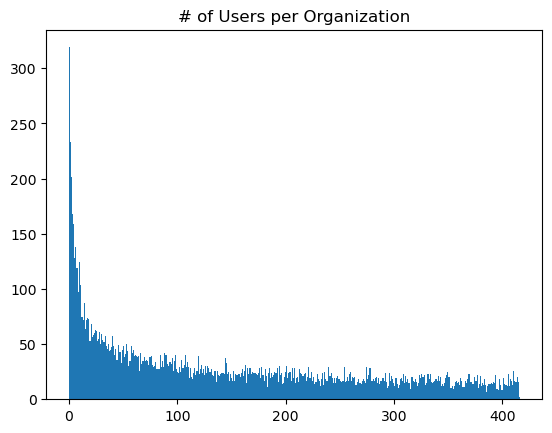

In [662]:
ax = df['org_id'].hist(bins=df['org_id'].nunique(), grid=False);
ax.set_title('# of Users per Organization');

In [663]:
# Add column with value counts for each organization id
df['users_per_org'] = df.groupby('org_id')['org_id'].transform('count')

In [666]:
df.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,lapsed_time,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,users_per_org
0,1,1.398139e+09,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,0,0.0,1,0,0,0,0,75
1,2,1.384487e+09,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,1,11750400.0,0,1,0,0,0,233
2,3,1.363735e+09,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,0,0.0,0,1,0,0,0,32
3,4,1.369124e+09,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,0,86400.0,1,0,0,0,0,233
4,5,1.358418e+09,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,0,432000.0,1,0,0,0,0,16


In [667]:
# Evaluate 'invited_by_user_id' column to potentially bin based on which user other users were invited by
df['invited_by_user_id'].value_counts().head()

invited_by_user_id
0.0        5583
10741.0      13
2527.0       12
1525.0       11
2308.0       11
Name: count, dtype: int64

In [668]:
# With this column having such a vast distribution, we won't use it

In [669]:
df.columns

Index(['object_id', 'creation_time', 'name', 'email',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted',
       'lapsed_time', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH',
       'users_per_org'],
      dtype='object')

In [670]:
# Create dataframe with relevant columns for modeling
dfm = df.drop(columns=['object_id', 'name', 'email', 'org_id', 'invited_by_user_id'])

In [671]:
dfm.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,adopted,lapsed_time,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,users_per_org
0,1.398139e+09,1.398139e+09,1,0,0,0.0,1,0,0,0,0,75
1,1.384487e+09,1.396238e+09,0,0,1,11750400.0,0,1,0,0,0,233
2,1.363735e+09,1.363735e+09,0,0,0,0.0,0,1,0,0,0,32
3,1.369124e+09,1.369210e+09,0,0,0,86400.0,1,0,0,0,0,233
4,1.358418e+09,1.358850e+09,0,0,0,432000.0,1,0,0,0,0,16


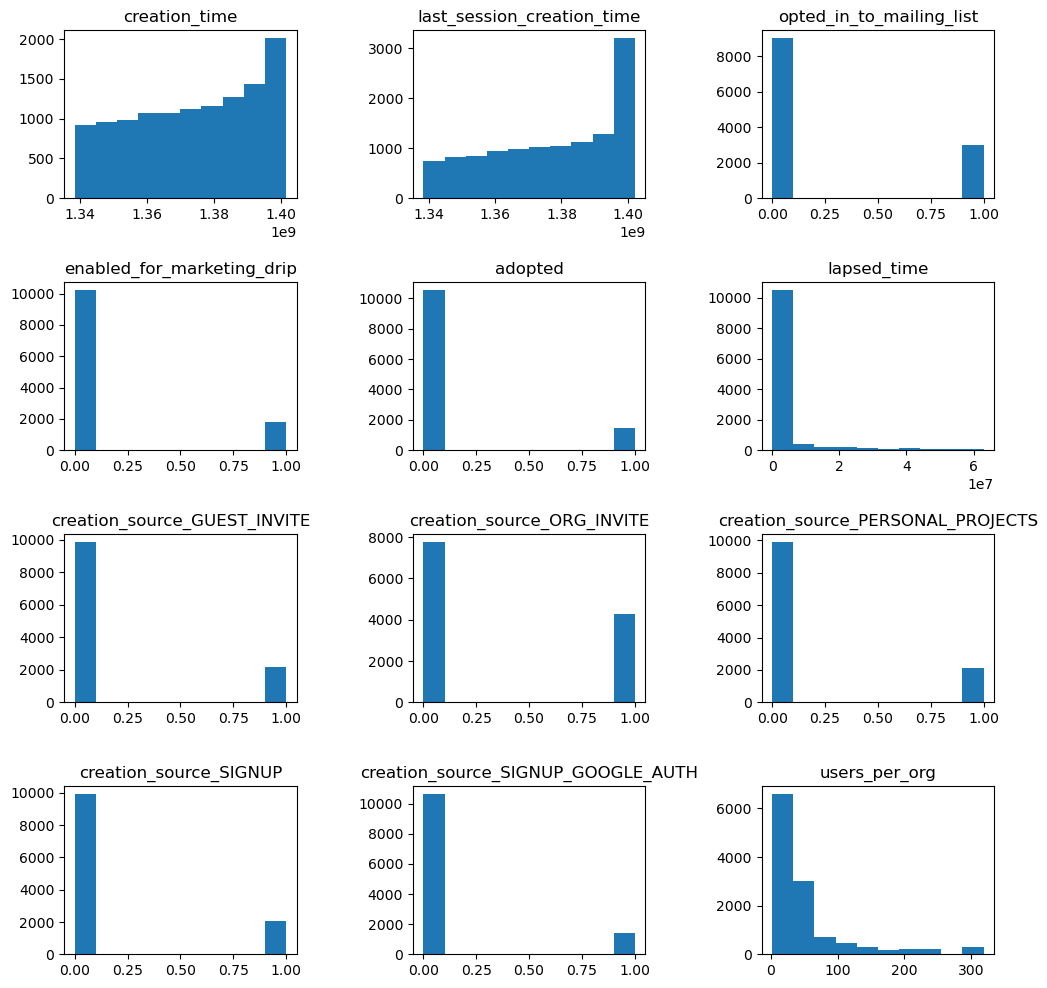

In [679]:
# Explore distributions of features and target
dfm.hist(grid=False, figsize=(12,12));
plt.subplots_adjust(hspace=0.5, wspace=0.5);

In [700]:
# We see that 'creation_time' and 'last_session_creation_time' are left skewed, while all other features are right skewed.

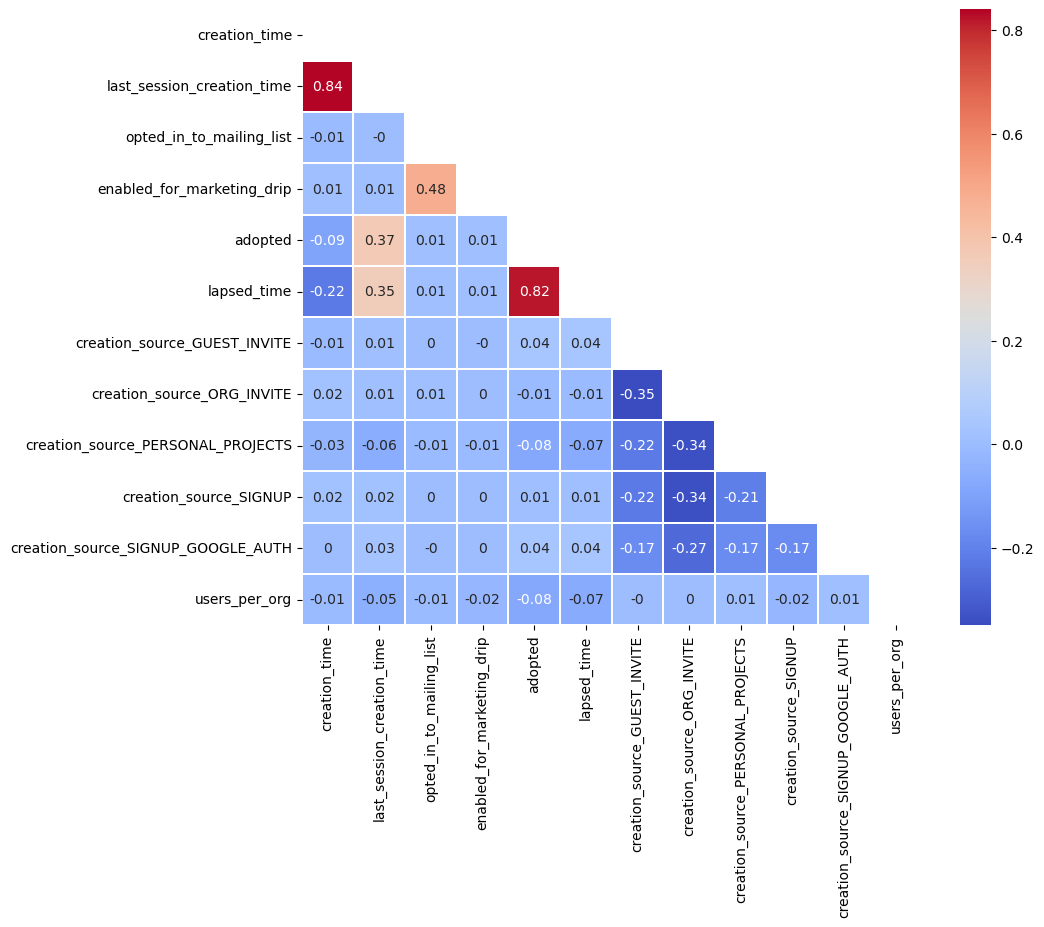

In [681]:
# Explore correlations of features and target
plt.figure(figsize=(10,8))
sns.heatmap(round(dfm.corr(),2),linewidths=.1,cmap='coolwarm', annot=True, mask=np.triu(dfm.corr()))
plt.yticks(rotation=0);

In [701]:
# Strongest positive correlations between 'last_session_creation_time' and 'creation_time', and 'lapsed_time' and 'adopted'.

In [684]:
# Split data into train and test sets for modeling
X = dfm.drop(columns='adopted')
y = dfm['adopted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [685]:
# Build predictive model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

In [686]:
# Accuracy score
print('Train accuracy:', accuracy_score(y_train, train_pred))
print('Test accuracy:', accuracy_score(y_test, test_pred))

Train accuracy: 1.0
Test accuracy: 0.9758333333333333


In [687]:
# Confusion matrix
cm = confusion_matrix(y_test, test_pred)
print(cm)
print('\nTrue negatives:', cm[0,0])
print('False negatives:', cm[1,0])
print('True positives:', cm[1,1])
print('False positives:', cm[0,1])

[[2085   21]
 [  37  257]]

True negatives: 2085
False negatives: 37
True positives: 257
False positives: 21


In [688]:
# Classification report
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2106
           1       0.92      0.87      0.90       294

    accuracy                           0.98      2400
   macro avg       0.95      0.93      0.94      2400
weighted avg       0.98      0.98      0.98      2400



In [690]:
# Feature importance
df_fi = pd.DataFrame({'Feature': X_test.columns, 'Importance': rf.feature_importances_}).sort_values('Importance', ascending=False).reset_index(drop=True)
df_fi

,Feature,Importance
0,lapsed_time,0.597372
1,last_session_creation_time,0.268308
2,creation_time,0.082919
3,users_per_org,0.030704
4,opted_in_to_mailing_list,0.004243
5,creation_source_ORG_INVITE,0.003015
6,creation_source_GUEST_INVITE,0.002870
7,creation_source_PERSONAL_PROJECTS,0.002744
8,enabled_for_marketing_drip,0.002649
9,creation_source_SIGNUP_GOOGLE_AUTH,0.002604


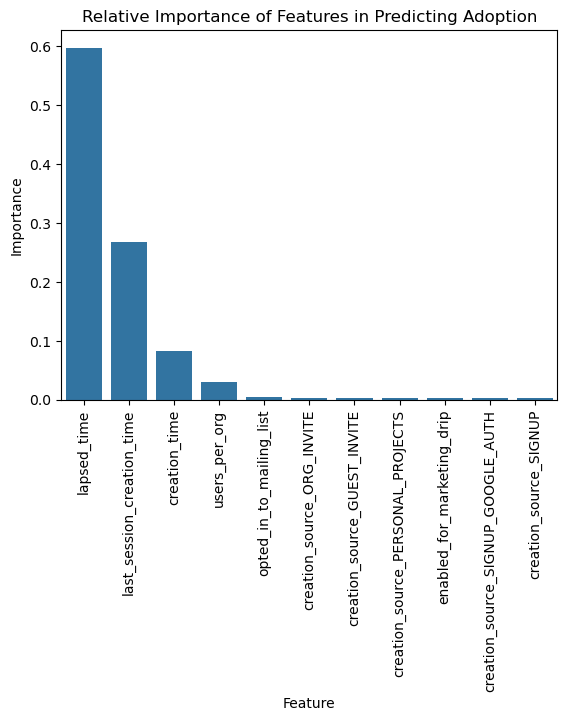

In [691]:
ax = sns.barplot(df_fi, x='Feature', y='Importance');
plt.xticks(rotation=90);
ax.set_title('Relative Importance of Features in Predicting Adoption');

According to our Random Forest Classifier, the factor that has the strongest influence on whether or not a user 'adopted' (e.g. if they logged into their account 3+ times in a given week), is the lapsed time between account creation and their most recent login. This makes intuitive sense, as a user whose most recent login has a longer lapsed time since thier account creation, indicates that they stuck with the account. On the contrary, many users who didn't adopt have a lapsed time of 0, indicating that they created an account (their first and last login), and never logged in again. For Relax to retain users, we hope to see a lapsed time > 0. Accordingly, the second and third most important features are the last session creation time, which represents a timestamp of the last login, and the creation time, a timestamp of their account creation, respectively. The fourth most important feature is the # users per organization. Since we know the organization ID of each user, we could count the total number of each organization ID to see which organizations had the most user representation.

It is interesting to note that 2 of the top 4 most important features were engineered, as in we created them based on information from other features. Our 'lapsed_time' feature was created by subtracting the creation time of the account from the last login time. The 'users_per_org' feature was created by counting the number of each organization ID. When we consider the effect of the other features, such as whether or not the user opted in to the mailing list, whether or not they enabled for the marketing drip, as well as the various creation source categories, the weight of these features might be obscured by the relative importance of our engineered features. These latter 7 features are all more closely clumped in relative importance than the top 4 features, but are still worth considering as they offer more information about our users. All present features considered, we note that the next (5th) most important feature is whether or not they opted in to the mailing list, and thee 6th most important feature is whether or not their account was created based on an invitation to join an organization as a full member.

Finally, considering that lapsed time is the most important in predicting adoption and (as shown from the heat map) this feature has a strong positive correlation with adoption, a primary goal for Relax should be to encourage users to login in to their account additional times after account creation. Incentives might include a reward system for consecutive day or week logins, or upcoming surprises that are advertised to users to encourage them to log in on a future date.